In [37]:
import importlib

import common

importlib.reload(common)

<module 'common' from 'C:\\Users\\j\\IdeaProjects\\fiit_masters_thesis_project\\jupyter\\common.py'>

In [38]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy
from common import create_engine, display_all, figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # converters e.g. for datetime in plots

In [3]:
engine = create_engine('db-conf.json', 'dp.kamko.dev')
pd.sql = lambda sql: pd.read_sql(sqlalchemy.text(sql), con=engine)

Nacitanie dat z db (live data z monant snapshotu)

In [4]:
fetch_data_query = '''
WITH fb_popularity AS (SELECT sbq.url, sbq.sync_date, sbq.reaction_count, sbq.comment_count, sbq.share_count
                       FROM (
                                SELECT afe.*, row_number() OVER (PARTITION BY url ORDER BY sync_date) as rn
                                FROM article_fb_engagement afe) sbq
                       WHERE sbq.rn = 1
)
SELECT a.id,
       a.url,
       title,
       perex,
       body,
       published_at,
       source_id,
       category,
       other_info,
       s.id           as source_id,
       name           as source_name,
       stype          as source_type,
       is_reliable    as source_is_reliable,
       sync_date      as fb_sync_date,
       reaction_count as fb_reaction_count,
       comment_count  as fb_comment_count,
       share_count    as fb_share_count,
       (reaction_count + comment_count + share_count) as fb_popularity
FROM article a
         JOIN source s on a.source_id = s.id
         JOIN (SELECT * FROM fb_popularity) p ON a.url = p.url
WHERE s.url !~ '(\.sk$)|(\.cz$)' -- remove cz/sk sources
  AND s.url NOT IN ('https://www.badatel.net', -- cz/sk portals not using cz/sk domain
                    'https://www.energiezivota.com',
                    'https://vedomec.com')
  AND a.published_at IS NOT NULL;
'''

df = pd.sql(fetch_data_query)

In [45]:
df.head()

,id,url,title,perex,body,published_at,source_id,category,other_info,source_id,source_name,source_type,source_is_reliable,fb_sync_date,fb_reaction_count,fb_comment_count,fb_share_count,fb_popularity
0,355149,http://blog.healthadvocate.com/2009/12/discove...,Discover Health Advocacy: Coverage for hospita...,"<p>We built our company, Health Advocate, Inc....","We built our company, Health Advocate, Inc., t...",2009-12-29 16:22:36,223,Advocacy in Action,"{'tags': ['Advocacy', 'Health Advocate', 'Heal...",223,healthadvocate.com,news_website,True,2019-10-14 21:53:23.370152,0,0,0,0
1,355150,http://blog.healthadvocate.com/2010/01/discove...,Discover Health Advocacy: Comparing medical costs,"<p>We built our company, Health Advocate, Inc....","We built our company, Health Advocate, Inc., t...",2010-01-18 16:54:05,223,Advocacy in Action,"{'tags': ['Benefits', 'Health Advocacy', 'Heal...",223,healthadvocate.com,news_website,True,2019-10-14 21:53:23.370164,0,0,0,0
2,355151,http://blog.healthadvocate.com/2010/01/discove...,Discover Health Advocacy: Underinsured patient...,"<p>We built our company, Health Advocate, Inc....","We built our company, Health Advocate, Inc., t...",2010-01-29 16:56:15,223,Advocacy in Action,"{'tags': ['Health Advocacy', 'Health Advocate'...",223,healthadvocate.com,news_website,True,2019-10-14 21:53:23.370171,0,0,0,0
3,355152,http://blog.healthadvocate.com/2010/02/discove...,Discover Health Advocacy: Coverage denied for ...,"<p>We built our company, Health Advocate, Inc....","We built our company, Health Advocate, Inc., t...",2010-02-04 16:59:52,223,Advocacy in Action,"{'tags': ['Health Advocacy', 'Health Advocate'...",223,healthadvocate.com,news_website,True,2019-10-14 21:53:23.370178,0,0,0,0
4,355153,http://blog.healthadvocate.com/2010/02/discove...,Discover Health Advocacy: Unreasonable balance...,"<p>We built our company, Health Advocate, Inc....","We built our company, Health Advocate, Inc., t...",2010-02-10 10:39:36,223,Advocacy in Action,"{'tags': ['Health Advocacy', 'Health Advocate'...",223,healthadvocate.com,news_website,True,2019-10-14 21:53:23.370185,0,0,0,0


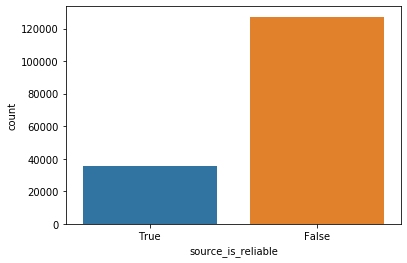

In [5]:
sns.countplot(x='source_is_reliable', data=df)

In [46]:
df['fb_popularity'].describe().apply(lambda x: '%.3f' % x)

count     165199.000
mean        1078.787
std        23826.760
min            0.000
25%            0.000
50%            1.000
75%           79.500
max      5197586.000
Name: fb_popularity, dtype: object

In [20]:
published_in_year = df.published_at.apply(lambda x: x.year)
published_in_year_month = df.published_at.apply(lambda x: (x.month, x.year))

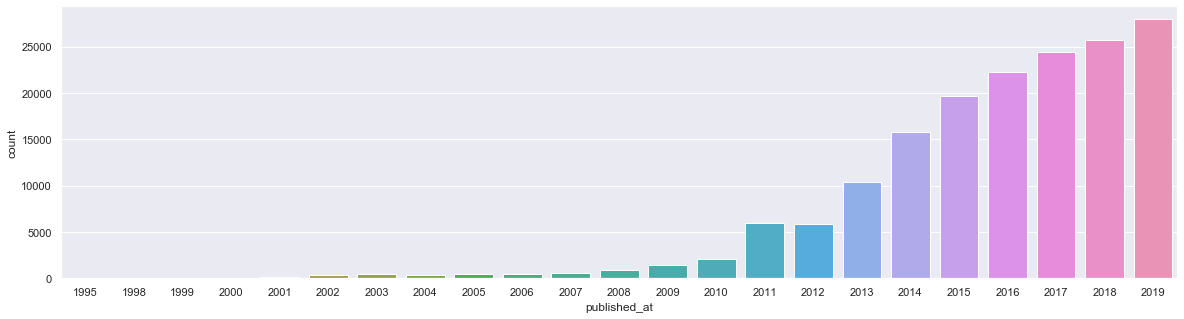

In [42]:
with figsize(plt, 20, 5):
    sns.countplot(published_in_year)